<a href="https://colab.research.google.com/github/Natasha617/DZ_NLP/blob/LDA%2CBigartm/DZ_5_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Описание работы

Загрузить набор данных Lenta.ru с помощью пакета Corus

Обучить модель LDA, постараться подобрать адекватные параметры (количество тем, проходы, альфа, итерации…) - 4 балла

Визуализировать результаты работы LDA с помощью pyLDAvis - 2 балла

Посчитать основные метрики обученных моделей LDA (с разными параметрами) и сравнить, соответствует ли метрика визуальному качеству работы моделей — 2 балла .

Обучить модель BigARTM, использовать не менее штатных двух датчиков, оценить качество с помощью метрики - 5 баллов.

Реализовать визуализацию топиков BigARTM через pyLDAvis - 4 балла

Обеспечена воспроизводимость решений: зафиксированы случайные_состояния, воспроизведение на ноутбуке происходит с начала до конца без ошибок - 2 балла.

Соблюдение стиля кода на уровне pep8 и Написание чистых блокнотов Jupyter — 1 балл

# Библиотеки

In [1]:
%%capture
!pip install corus
!pip install gensim
!python3 -m spacy download ru_core_news_sm
!pip install pyldavis
!pip install --upgrade ipykernel
!pip install pymorphy2 pyLDAvis bigartm corus razdel
!wget https://github.com/yutkin/Lenta.Ru-News-Dataset/releases/download/v1.1/lenta-ru-news.csv.bz2

In [28]:
from corus import load_lenta2
import numpy as np
import spacy
from spacy import displacy
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from gensim import corpora
from gensim import models
from gensim.models import LdaModel
import pyLDAvis
import pyLDAvis.gensim
from sklearn.feature_extraction.text import CountVectorizer
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import artm

import matplotlib.pyplot as plt
%matplotlib inline

print(artm.version())

0.9.2


# Очистка текста

In [4]:
path = 'lenta-ru-news.csv.bz2'
records = load_lenta2(path)
next(records)

LentaRecord(
    url='https://lenta.ru/news/1914/09/16/hungarnn/',
    title='1914. Русские войска вступили в\xa0пределы Венгрии  ',
    text='Бои у Сопоцкина и Друскеник закончились отступлением германцев. Неприятель, приблизившись с севера к Осовцу начал артиллерийскую борьбу с крепостью. В артиллерийском бою принимают участие тяжелые калибры. С раннего утра 14 сентября огонь достиг значительного напряжения. Попытка германской пехоты пробиться ближе к крепости отражена. В Галиции мы заняли Дембицу. Большая колонна, отступавшая по шоссе от Перемышля к Саноку, обстреливалась с высот нашей батареей и бежала, бросив парки, обоз и автомобили. Вылазки гарнизона Перемышля остаются безуспешными. При продолжающемся отступлении австрийцев обнаруживается полное перемешивание их частей, захватываются новые партии пленных, орудия и прочая материальная часть. На перевале Ужок мы разбили неприятельский отряд, взяли его артиллерию и много пленных и, продолжая преследовать, вступили в пределы Венгрии

In [5]:
dataset = [next(records).text for i in range(1000)]
dataset[0]


'Министерство народного просвещения, в виду происходящих чрезвычайных событий, признало соответственным в день годовщины со дня рождения М.Ю. Лермонтова (2-го октября 1914 года) ограничиться совершением в учебных заведениях панихиды по поэту, отложив празднование юбилея до более благоприятного времени.  «Русский инвалид», 16 сентября 1914 года.'

In [6]:
nlp = spacy.load('ru_core_news_sm')
nlp.pipe_names

['tok2vec', 'morphologizer', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

In [7]:
def preprocess(data):
  ds = []
  for el in data:
    x=[]
    for token in nlp(el):
      if not token.is_stop and not token.is_punct and not token.is_digit and not token.like_email and not token.like_num and not token.is_space and not token.is_bracket:
        x.append(token.lemma_.lower())
    ds.append(x)
  return ds

In [8]:
%%time
data= preprocess(dataset)

CPU times: user 2min 9s, sys: 266 ms, total: 2min 10s
Wall time: 2min 12s


In [9]:
data[:2]

[['министерство',
  'народный',
  'просвещение',
  'вид',
  'происходить',
  'чрезвычайный',
  'событие',
  'признать',
  'соответственный',
  'день',
  'годовщина',
  'день',
  'рождение',
  'м.ю.',
  'лермонтов',
  '2-й',
  'октябрь',
  'год',
  'ограничиться',
  'совершение',
  'учебный',
  'заведение',
  'панихиды',
  'поэт',
  'отложить',
  'празднование',
  'юбилей',
  'благоприятный',
  'время',
  'русский',
  'инвалид',
  'сентябрь',
  'год'],
 ['штабс',
  'капитан',
  'п.',
  'н.',
  'нестеров',
  'день',
  'увидеть',
  'район',
  'желтиева',
  'галиции',
  'лететь',
  'расположение',
  'австрийский',
  'аэроплан',
  'собиравшийся',
  'бросить',
  'бомба',
  'взлететь',
  'воздух',
  'атаковать',
  'неприятель',
  'протаранить',
  'неприятельский',
  'аппарат',
  'предотвратить',
  'жертва',
  'войско',
  'нестеров',
  'погибнуть',
  'смерть',
  'герой',
  'слово',
  'доставить',
  'киев',
  'пленный',
  'австрийский',
  'офицер',
  'неприятельский',
  'армия',
  'известный',


In [10]:
vectorizer = TfidfVectorizer(max_df=0.24, min_df=0.02) # между max_df=0.22 и max_df=0.8 разница всего в 5 слов
vectorizer.fit_transform([' '.join(lst) for lst in data])

<1000x915 sparse matrix of type '<class 'numpy.float64'>'
	with 44882 stored elements in Compressed Sparse Row format>

In [11]:
print(len(vectorizer.stop_words_))

17276


In [12]:
# создание списка стоп слов
def remove_stopwords(texts):
    return [[word for word in text if word not in vectorizer.stop_words_] for text in texts]

In [13]:
data_cleaned = remove_stopwords(data)
data_cleaned[:2]

[['министерство',
  'народный',
  'вид',
  'происходить',
  'чрезвычайный',
  'событие',
  'признать',
  'день',
  'день',
  'м.ю.',
  '2-й',
  'октябрь',
  'русский',
  'сентябрь'],
 ['п.',
  'н.',
  'день',
  'район',
  'аппарат',
  'предотвратить',
  'жертва',
  'войско',
  'погибнуть',
  'доставить',
  'офицер',
  'армия',
  'известный',
  'имя',
  'воздушный',
  'разведка',
  'русский',
  'аппарат',
  'усилие',
  'направить',
  'деятельность',
  'объявить',
  'больший',
  'погибнуть',
  'остаться',
  'ребёнок',
  '5-ти',
  '3-х',
  '№',
  'сентябрь',
  'направить',
  'земля',
  'война',
  'противник',
  'круг',
  'рука',
  'машина',
  'решение',
  'знать',
  'противник',
  '№',
  'сентябрь']]

# LDA Model

In [14]:
my_dictionary = corpora.Dictionary(data_cleaned) # создаем словарь
my_dictionary[0]

'2-й'

In [15]:
bow_corpus =[my_dictionary.doc2bow(l) for l in data_cleaned] # преобразование  слов в Bag of Word
bow_corpus[0]


[(0, 1),
 (1, 1),
 (2, 2),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1)]

In [16]:

lda_model = gensim.models.ldamodel.LdaModel(corpus=bow_corpus,
                                           id2word=my_dictionary,
                                           num_topics=10,
                                           random_state=140,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

print(lda_model.print_topics(-1))

[(0, '0.015*"список" + 0.014*"принять" + 0.013*"федеральный" + 0.013*"решение" + 0.011*"депутат" + 0.011*"кандидат" + 0.010*"государственный" + 0.010*"совет" + 0.009*"председатель" + 0.009*"область"'), (1, '0.021*"находиться" + 0.019*"данным" + 0.018*"результат" + 0.015*"произойти" + 0.014*"район" + 0.014*"час" + 0.014*"дом" + 0.014*"место" + 0.014*"погибнуть" + 0.013*"самолёт"'), (2, '0.072*"банк" + 0.060*"счёт" + 0.057*"деньга" + 0.057*"газета" + 0.040*"bank" + 0.038*"дело" + 0.033*"new" + 0.031*"york" + 0.027*"of" + 0.022*"фирма"'), (3, '0.026*"сша" + 0.025*"новый" + 0.020*"страна" + 0.016*"система" + 0.015*"проект" + 0.014*"американский" + 0.014*"интернет" + 0.013*"правительство" + 0.012*"мир" + 0.012*"министр"'), (4, '0.039*"чечня" + 0.037*"военный" + 0.025*"сила" + 0.023*"дело" + 0.021*"территория" + 0.020*"генерал" + 0.020*"дагестан" + 0.020*"войско" + 0.020*"граница" + 0.020*"оружие"'), (5, '0.041*"москва" + 0.034*"президент" + 0.028*"премьер" + 0.026*"министр" + 0.025*"правите

In [17]:
# Обучение, попробовала чуть-чуть по-другому
LDA_model = LdaModel(corpus=bow_corpus, id2word=my_dictionary, num_topics=10)
# сохранение модели
LDA_model.save('LDA_model.model')
# показать темы
print(LDA_model.print_topics(-1))

[(0, '0.011*"москва" + 0.011*"сша" + 0.010*"дело" + 0.009*"доллар" + 0.008*"компания" + 0.007*"военный" + 0.007*"американский" + 0.005*"рф" + 0.005*"дом" + 0.005*"информация"'), (1, '0.010*"министр" + 0.009*"сша" + 0.007*"представитель" + 0.007*"страна" + 0.007*"новый" + 0.006*"система" + 0.006*"территория" + 0.006*"сторона" + 0.006*"дело" + 0.006*"список"'), (2, '0.013*"новый" + 0.009*"сша" + 0.008*"страна" + 0.007*"сила" + 0.007*"район" + 0.007*"министр" + 0.006*"погибнуть" + 0.006*"президент" + 0.006*"город" + 0.006*"дом"'), (3, '0.013*"правительство" + 0.010*"москва" + 0.009*"министр" + 0.008*"владимир" + 0.007*"путин" + 0.007*"рф" + 0.007*"глава" + 0.007*"республика" + 0.006*"отметить" + 0.006*"гражданин"'), (4, '0.007*"страна" + 0.007*"оон" + 0.007*"взрыв" + 0.007*"дом" + 0.006*"компания" + 0.006*"доллар" + 0.006*"данным" + 0.006*"интернет" + 0.006*"президент" + 0.005*"представитель"'), (5, '0.010*"суд" + 0.009*"москва" + 0.008*"дело" + 0.007*"чечня" + 0.007*"пресс" + 0.007*"сила

In [18]:
# вероятность принадлежности слова к теме
LDA_model.get_term_topics('машина')

print(bow_corpus[:3])
# интерпретация данных
doc_topics, word_topics, phi_values = LDA_model.get_document_topics(bow_corpus[:3], per_word_topics=True)

[[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1)], [(2, 1), (9, 1), (10, 2), (13, 1), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 2), (32, 1), (33, 1), (34, 1), (35, 1), (36, 2), (37, 1), (38, 2), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 2)], [(10, 1), (20, 1), (34, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1)]]


## **Визуализация**

In [19]:
import pyLDAvis.gensim_models as gensimvis

In [20]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, bow_corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.138718 -0.043219       1        1  19.170900
0      0.139665 -0.138805       2        1  18.599565
1     -0.152652  0.154266       3        1  12.554387
5     -0.044813 -0.173201       4        1  10.790986
9     -0.136184  0.029808       5        1   9.915587
4     -0.177662 -0.020063       6        1   8.348543
6      0.173969  0.276326       7        1   7.571787
2      0.039209  0.157085       8        1   4.511372
7     -0.178623 -0.094106       9        1   4.278505
8      0.198374 -0.148091      10        1   4.258367, topic_info=           Term        Freq       Total Category  logprob  loglift
261    компания  333.000000  333.000000  Default  30.0000  30.0000
138      москва  422.000000  422.000000  Default  29.0000  29.0000
174      доллар  273.000000  273.000000  Default  28.0000  28.0000
249        банк  251.000000  251.000000  Default  27.0000  27.0000
253        дело  383.000000  383.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
355          рф   32.636855  255.436045  Topic10  -4.3768   1.0988
111    средство   28.746340  125.574582  Topic10  -4.5038   1.6819
290       связь   29.746423  217.853201  Topic10  -4.4696   1.1652
261    компания   28.422523  333.913675  Topic10  -4.5151   0.6926
418  информация   26.063412  233.050453  Topic10  -4.6017   0.9656

[535 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
1355     10  0.750521            .ru
1470      8  0.790121        /hsbc/.
1041      9  0.896627            1-й
1423      9  0.414871  200-граммовых
934      10  0.785785            7-й
...     ...       ...            ...
333       8  0.046380       являться
333      10  0.056687       являться
1083      3  0.325844        ядерный
1083      6  0.663755        ядерный
45        3  0.959536              №

[919 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 6, 10, 5, 7, 3, 8, 9])

Вывод: модель сработала достаточно хорошо
Видно разделение по темам

# **BigARTM**

In [22]:
data = [' '.join(token_list) for token_list in data]
cv = CountVectorizer(max_features=10000, max_df=0.9, min_df=0.05, ngram_range=(1, 2))
n_wd = np.array(cv.fit_transform(data).todense()).T
token_list = [i for i in cv.vocabulary_.keys()]

bv = artm.BatchVectorizer(data_format='bow_n_wd', n_wd=n_wd, vocabulary=token_list)

/usr/local/lib/python3.10/dist-packages/artm/batches_utils.py:227: DeprecationWarning: Please use `spmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.base` namespace is deprecated.
  from scipy.sparse.base import spmatrix


In [23]:
# задача для оптимизации в ходе поиска гиперпараметров модели

def minimalisation_task(space):
    model = artm.ARTM(num_topics=space['num_topics'], dictionary=bv.dictionary, cache_theta=True)

    model.scores.add(artm.PerplexityScore(name='perplexity_score', dictionary=bv.dictionary))
    model.scores.add(artm.SparsityPhiScore(name='sparsity_phi_score'))
    model.scores.add(artm.SparsityThetaScore(name='sparsity_theta_score'))
    model.scores.add(artm.TopTokensScore(name='top_tokens_score', num_tokens=10000))

    model.regularizers.add( # Сглаживание распределений терминов в темах. Используется для выделения фоновых тем, собирающих общую лексику языка или общую лексику данной коллекции.
        artm.SmoothSparsePhiRegularizer(
            name='SparsePhi',
            tau=space['phi_tau']
    ))
    model.regularizers.add( # Сглаживание распределений тем в документах. Используется для выделения фоновых слов в каждом документах.
        artm.SmoothSparseThetaRegularizer(
            name='SparseTheta',
            tau=space['theta_tau']
        ))
    model.regularizers.add(  # Декоррелирование распределений терминов в темах. Используется для повышения различности лексических ядер предметных тем.
        artm.DecorrelatorPhiRegularizer(
            name='DecorrelatorPhi',
            tau=space['decorrelation_tau']
        ))

    model.fit_offline(bv, num_collection_passes=30)

    perplexity_score = model.score_tracker["perplexity_score"].last_value
    print("Perplexity:", perplexity_score)

    return {'loss': perplexity_score, 'status': STATUS_OK }

In [24]:
def run_hyperparams_search(minimalisation_task):
    num_topics = [10, 11, 12, 13]
    space={
        'num_topics': hp.choice('num_topics', num_topics),
        'phi_tau': hp.uniform('SparsePhi', -1, 1),
        'theta_tau': hp.uniform('SparseTheta', -1, 1),
        'decorrelation_tau': hp.uniform('DecorrelatorPhi', 1e+2, 1e+5),
    }

    trials = Trials()

    best_hyperparams = fmin(
        fn=minimalisation_task,
        space=space,
        algo=tpe.suggest,
        max_evals=25,
        trials=trials
    )

    best_hyperparams['num_topics'] = num_topics[best_hyperparams['num_topics']]
    return best_hyperparams


def fit_best_model(best_params, bv, seed):
    model = artm.ARTM(num_topics=best_params['num_topics'], dictionary=bv.dictionary, cache_theta=True, seed=seed)
    model.scores.add(artm.PerplexityScore(name='perplexity_score',
                                         dictionary=bv.dictionary))

    model.scores.add(artm.SparsityPhiScore(name='sparsity_phi_score'))
    model.scores.add(artm.SparsityThetaScore(name='sparsity_theta_score'))
    model.scores.add(artm.TopTokensScore(name='top_tokens_score', num_tokens=10000))

    model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=best_params['SparsePhi'])) # сглаживание/разреживание матрицы Phi
    model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=best_params['SparseTheta'])) # сглаживание/разреживание матрицы Theta
    model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=best_params['DecorrelatorPhi'])) # сделать темы более разнообразными

    model.fit_offline(bv, num_collection_passes=30)
    return model


def prepare_vis_data(model, n_wd):
    phi = model.get_phi()
    theta = model.get_theta().to_numpy().T
    theta = theta / theta.sum(axis=1, keepdims=1)
    data = {'topic_term_dists': phi.to_numpy().T,
            'doc_topic_dists': theta,
            'doc_lengths': n_wd.sum(axis=0).tolist(),
            'vocab': phi.T.columns,
            'term_frequency': n_wd.sum(axis=1).tolist()}
    return data

In [ ]:
# найдем параметры для минимальной перплексии
best_hyperparams = run_hyperparams_search(minimalisation_task)
best_hyperparams

In [26]:
%%time
model = fit_best_model(best_hyperparams, bv, seed=12)

CPU times: user 963 ms, sys: 16.1 ms, total: 979 ms
Wall time: 1.01 s


Text(0.5, 0, 'epoch')

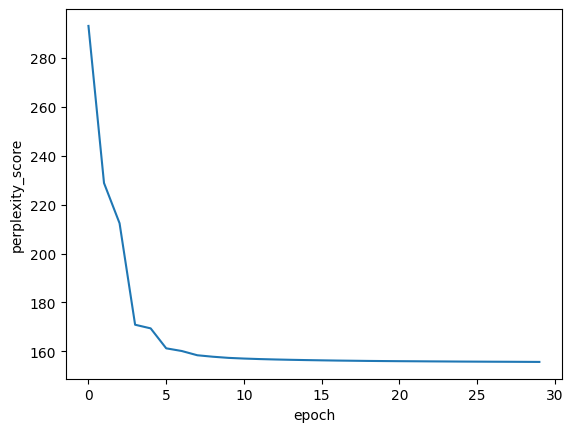

In [29]:
plt.plot(model.score_tracker["perplexity_score"].value)
plt.ylabel('perplexity_score')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

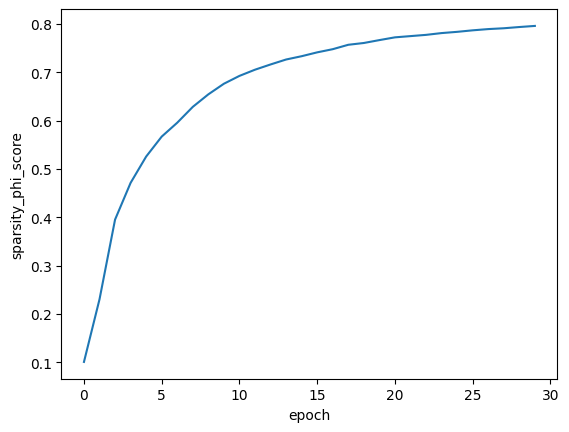

In [30]:
plt.plot(model.score_tracker["sparsity_phi_score"].value)
plt.ylabel('sparsity_phi_score')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

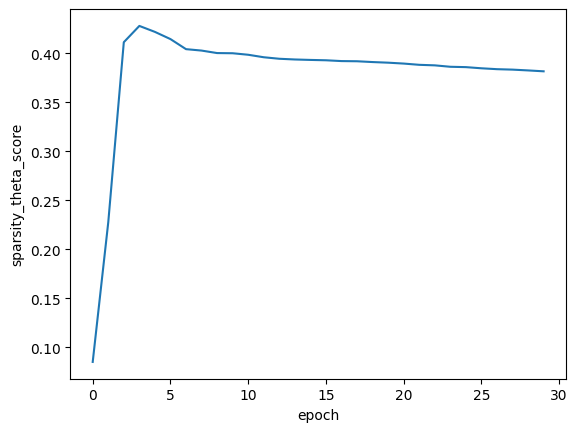

In [31]:
plt.plot(model.score_tracker["sparsity_theta_score"].value)
plt.ylabel('sparsity_theta_score')
plt.xlabel('epoch')

In [32]:
pyLDAvis.enable_notebook()
model_data = prepare_vis_data(model, n_wd)
model_vis = pyLDAvis.prepare(**model_data)
pyLDAvis.display(model_vis)

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


Модель LDA работала лучше